In [15]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.utils import shuffle

from tools import plot_confusion_matrix

In [16]:
df = pd.read_csv('../data/datatran_2016-2017.csv', dtype={'br_str': str})
df.shape

/Users/leportella/.virtualenvs/udacity/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(180991, 32)

In [17]:
df.target.value_counts()

1    106534
0     64166
2     10291
Name: target, dtype: int64

In [18]:
class0 = df[df.target==0].sample(10291)
class1 = df[df.target==1].sample(10291)
class2 = df[df.target==2]

df2 = shuffle(pd.concat([class0, class1, class2]))

In [19]:
dd = df2[['weekday', 'uf', 'br_str', 'km_int', 'accident_cause_simplified', 'accident_type', 
        'moment_of_day', 'climate','road_layout','target']]
dd = dd.dropna()

In [20]:
dd.target.value_counts()

2    10291
1    10291
0    10291
Name: target, dtype: int64

In [21]:
dd.shape

(30873, 10)

In [22]:
X = pd.get_dummies(dd.drop(['target'], axis=1))
y = dd['target']

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_PCA = pca.fit_transform(X)

In [24]:
model_class0 = joblib.load('../model/model_v10-no-victms.pkl')
model_class1 = joblib.load('../model/model_v10-injuried-victims.pkl')
model_class2 = joblib.load('../model/model_v10-dead-victims.pkl')

In [25]:
y_predict_class0 = model_class0.predict_proba(X_PCA)
y_predict_class1 = model_class1.predict_proba(X_PCA)
y_predict_class2 = model_class2.predict_proba(X_PCA)

df_predict = pd.DataFrame({
    'class_0': y_predict_class0[:,1],
    'class_1': y_predict_class1[:,1],
    'class_2': y_predict_class2[:,1],
})

In [26]:
X_final = pd.concat([df_predict, pd.DataFrame(X_PCA)], axis=1)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [28]:
model = LogisticRegression()

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1., 1.5],
    'class_weight': ['balanced', None]
}


scorer = make_scorer(score_func=accuracy_score)

grid_obj = GridSearchCV(model, parameters, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

In [29]:
y_pred = best_clf.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.5609716599190283

Confusion matrix, without normalization
[[1420  495  175]
 [ 774  788  449]
 [ 454  364 1256]]


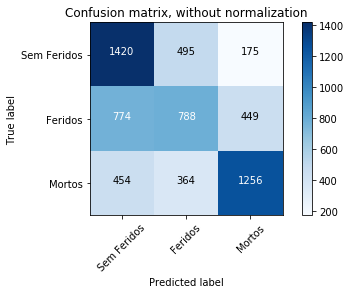

In [31]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=['Sem Feridos', 'Feridos', 'Mortos'],
                      title='Confusion matrix, without normalization')

In [32]:
from sklearn.metrics import f1_score, classification_report

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.54      0.68      0.60      2090
          1       0.48      0.39      0.43      2011
          2       0.67      0.61      0.64      2074

avg / total       0.56      0.56      0.56      6175

